# Numerical solution of the Helmholtz equation
## Description

### PDE
We will try to solve the following pde:

$\Delta \psi(x, y) +k^2\psi(x, y) = -f(x, y)$ on $\Omega = [0,1]^2$  

where $f(x, y)=2k^2e^{jk(x+y)}-k^2e^{jk(x+y)} = k^2e^{jk(x+y)}$   

### Boundary conditions    
$\psi(0,y)=e^{jky}, \quad \psi(1,y)=e^{jk(1+y)}, \quad \psi(x,0)=e^{jkx} \quad$ and $\quad \psi(x,1)=e^{jk(x+1)} $

### Loss function
The loss to minimize here is $\mathcal{L} = \frac{1}{N}||\Delta \psi(x, y) +k^2\psi(x, y)+f(x, y) ||_2^2$, where N is the size of the training data

### Analytical solution
The solution $\psi_{th}$ should be $\psi_{th}(x, y)=e^{jk(x+y)}$  

### Approximated solution
We want to find a approximated solution $\psi_{a}(x, y)=A(x, y)+F(x, y)N(x, y)$
s.t:  

$F(x, y)=\sin(x)\sin(y)\sin(x-1)\sin(y-1)$ 

$A(x, y)=(1-x)e^{jky}+xe^{jk(1+y)} + (1-y)\{e^{jkx}-[(1-x)+xe^{jk}]\} + y\{e^{jk(x+1)}-[(1-x)e^{jk}+xe^{j2k}]\}$   


# Libraries

In [16]:
import jax, optax
import pickle
import functools
import matplotlib.pyplot
import numpy
%matplotlib inline

# Set and verify device
jax.config.update('jax_platform_name', 'gpu')
jax.config.update("jax_enable_x64", True)
print(jax.lib.xla_bridge.get_backend().platform)

gpu


# Parameters

In [4]:
# Neural network parameters
parameters = {}
parameters['seed'] = 351
parameters['n_features'] = 2        # Input dimension (x1, x2)
parameters['n_targets'] = 2         # Output dimension. It's a complex number (y1 + j*y2)
parameters['hidden_layers'] = [50, 50, 50, 50, 50]   # Hidden layers structure
parameters['layers'] = [parameters['n_features']] + parameters['hidden_layers'] + [parameters['n_targets']]

# Training parameters
parameters['learning_rate'] = optax.linear_schedule(0.005, 0.00001, transition_steps = 50, transition_begin = 5000)
parameters['optimizer'] = optax.adam(parameters['learning_rate'])
parameters['maximum_num_epochs'] = 50000
parameters['report_steps'] = 1000
parameters['options'] = 2           # 1: we start a new training. 2: We continue the last training. 
                                    # Other cases: We just load the last training

# Data parameters
parameters['batch_size'] = 100
parameters['domain_bounds'] = jax.numpy.column_stack(([0.0, 0.0], [1.0, 1.0]))   # minimal and maximal value of each axis (x, y)

# Neural network

In [5]:
class MLP:
    """
        Create a multilayer perceptron and initialize the neural network
    Inputs :
        A SEED number and the layers structure
    """
    def __init__(self, key, layers):
        self.key = key
        self.keys = jax.random.split(self.key,len(layers))
        self.layers = layers
        self.params = []

    def MLP_create(self):
        """
        Initialize the MLP weigths and bias
        Parameters
        ----------
        Returns
        -------
        params : list of parameters[[w1,b1],...,[wn,bn]]
            -- weights and bias
        """
        for layer in range(0, len(self.layers)-1):
            in_size,out_size = self.layers[layer], self.layers[layer+1]
            weights = jax.nn.initializers.glorot_normal()(self.keys[layer], (out_size, in_size), jax.numpy.float32)
            bias = jax.nn.initializers.lecun_normal()(self.keys[layer], (out_size, 1), jax.numpy.float32).reshape((out_size, ))
            self.params.append((weights, bias))
        return self.params
        

    @functools.partial(jax.jit, static_argnums=(0,))    
    def NN_evaluation(self, params, inputs):
        """
        Evaluate a position (x,y) using the neural network    
        Parameters
        ----------
        params : list of parameters[[w1,b1],...,[wn,bn]]
            -- weights and bias
        inputs : jax.numpy.ndarray[[batch_size,batch_size]]
            -- points in the domain
        Returns
        -------
        output : jax.numpy.array[batch_size]
            -- neural network output 
        """
        for layer in range(0, len(params)-1):
            weights, bias = params[layer]
            inputs = jax.nn.tanh(jax.numpy.add(jax.numpy.dot(inputs, weights.T), bias))
        weights, bias = params[-1]
        real_and_imaginary_layers = jax.numpy.dot(inputs, weights.T)+bias  # The first output of the NN is the real part, the second is the imaginary part
        output = jax.lax.complex(real_and_imaginary_layers[0], real_and_imaginary_layers[1])  

        return output


# Operators

In [6]:
class PDE_operators:
    """
        Class with the operators used to solve the PDE
    Input:
        A function that we want to compute the respective operator
    """
    def __init__(self, function):
        self.function = function

    @functools.partial(jax.jit, static_argnums=(0,))    
    def laplacian_2d(self, params, inputs):
        """
        Compute the two dimensional laplacian.
        Parameters
        ----------
        params : list of parameters[[w1,b1],...,[wn,bn]]
            -- weights and bias
        inputs : jax.numpy.ndarray[[batch_size,batch_size]]
            -- coordinates (x, y)
        Returns
        -------
        laplacian : jax.numpy.ndarray[batch_size]
            -- numerical values of the laplacian applied to the inputs
        """
        fun = lambda params,x, y: self.function(params, x, y)
        @functools.partial(jax.jit)    
        def action(params,x, y):
            u_xx = jax.jacfwd(jax.jacfwd(fun, 1), 1)(params,x, y)
            u_yy = jax.jacfwd(jax.jacfwd(fun, 2), 2)(params,x, y)
            return u_xx + u_yy
        vec_fun = jax.vmap(action, in_axes = (None, 0, 0))
        laplacian = vec_fun(params, inputs[:,0], inputs[:,1]).flatten()
        return laplacian

# Physics Informed Neural Network

In [7]:
class PINN:
    """
    Solve a PDE using Physics Informed Neural Networks   
    Input:
        The evaluation function of the neural network and the optimizer selected to do gradient descent
    """
    def __init__(self, NN_evaluation, optimizer):
        self.NN_evaluation = NN_evaluation
        self.optimizer = optimizer

        self.operators = PDE_operators(self.spatial_solution2d)
        self.laplacian2d = self.operators.laplacian_2d

        self.k_coeff = 0.5  # Wavenumber


    @functools.partial(jax.jit, static_argnums = (0, ))    
    def spatial_solution2d(self, params, inputX, inputY):
        """
        Compute the complex solution of the PDE on the points (x, y)
        Parameters
        ----------
        params : list of parameters[[w1,b1],...,[wn,bn]]
            -- weights and bias
        inputX : jax.numpy.array[batch_size]
            -- points on the x-axis of the domain
        inputY : jax.numpy.array[batch_size]
            -- points on the y-axis of the domain
        Returns
        -------
        applied_solution : jax.numpy.array[batch_size]
            -- PINN solution applied to inputs. return F_NN_plus_A, a complex array
        """
        inputs = jax.numpy.column_stack((inputX, inputY))
        NN = jax.vmap(functools.partial(jax.jit(self.NN_evaluation), params))(inputs)
        F = self.F_function(inputX,inputY)
        A = self.A_function(inputX,inputY)
        F_NN_plus_A = jax.numpy.add(jax.numpy.multiply(F, NN), A).reshape(-1)
        return F_NN_plus_A


    # Definition of the function A(x, y) mentioned above   
    @functools.partial(jax.jit, static_argnums = (0, ))    
    def A_function(self, inputX, inputY):
        """
        Compute A(x, y) on the inputs
        Parameters
        ----------
        inputX : jax.numpy.ndarray[batch_size]
            -- points in the axis x
        inputY : jax.numpy.ndarray[batch_size]
            -- points in the axis y
        Returns
        -------
        A_output : jax.numpy.array[batch_size]
            -- A(x, y) applied to inputs
        """
        j_number = jax.lax.complex(0.0,1.0)
        A1 = (1-inputX)*jax.numpy.exp(j_number*self.k_coeff*inputY) + inputX*jax.numpy.exp(j_number*self.k_coeff*(1+inputY))
        A2 = (1-inputY)*(jax.numpy.exp(j_number*self.k_coeff*inputX) - ((1-inputX) + inputX*jax.numpy.exp(j_number*self.k_coeff)))
        A3 = inputY*(jax.numpy.exp(j_number*self.k_coeff*(inputX + 1)) - ((1-inputX)*jax.numpy.exp(j_number*self.k_coeff) + inputX*jax.numpy.exp(j_number*2*self.k_coeff)))
        A_output = A1 + A2 + A3
        return A_output


    # Definition of the function F(x, y) mentioned above   
    @functools.partial(jax.jit, static_argnums = (0, ))    
    def F_function(self, inputX, inputY):
        """
        Compute F(x, y) on the inputs
        Parameters
        ----------
        inputX : jax.numpy.ndarray[batch_size]
            -- points in the axis x
        inputY : jax.numpy.ndarray[batch_size]
            -- points in the axis y
        Returns
        -------
        F_output : jax.numpy.array[batch_size]
            -- F(x, y) applied to inputs
        """
        F1 = jax.numpy.multiply(jax.numpy.sin(inputX), jax.numpy.sin(inputX - 1))
        F2 = jax.numpy.multiply(jax.numpy.sin(inputY), jax.numpy.sin(inputY - 1))
        F_output = jax.numpy.multiply(F1, F2)
        return F_output


    # Definition of the function f(x, y) mentioned above   
    @functools.partial(jax.jit, static_argnums = (0, ))    
    def exact_function(self, inputs):
        """
        Compute f(x, y) on the inputs
        Parameters
        ----------
        inputs : jax.numpy.ndarray[[batch_size, batch_size]]
            -- (x, y) points from the domain
        Returns
        -------
        exact_output : jax.numpy.array[batch_size]
            -- f(x, y) applied to inputs
        """
        j_number = jax.lax.complex(0.0,1.0)
        exact_output = self.k_coeff**2*jax.numpy.exp(j_number*self.k_coeff*(inputs[:,0] + inputs[:,1]))
        return exact_output


    # Definition of the pde mentioned above   
    @functools.partial(jax.jit, static_argnums = (0, ))    
    def pde_function(self, params, inputs):
        """
        Compute the pde on the inputs
        Parameters
        ----------
        params : list of parameters[[w1,b1],...,[wn,bn]]
            -- weights and bias
        inputs : jax.numpy.ndarray[[batch_size, batch_size]]
            -- (x, y) points from the domain
        Returns
        -------
        pde_value : jax.numpy.array[batch_size]
            -- pde applied to inputs
        """
        pde_value = self.laplacian2d(params, inputs) + self.k_coeff**2*self.spatial_solution2d(params, inputs[:,0], inputs[:,1])
        return pde_value


    # Definition of the loss function mentioned above   
    @functools.partial(jax.jit, static_argnums = (0, ))    
    def loss_function(self, params, inputs):
        """
        Compute the loss of the pde inside the domain
        Parameters
        ----------
        params : list of parameters[[w1,b1],...,[wn,bn]]
            -- weights and bias
        inputs : jax.numpy.ndarray[[batch_size, batch_size]]
            -- (x, y) points from the domain
        Returns
        -------
        loss_value : a float64
            -- loss function applied to inputs
        """
        residual = self.pde_function(params, inputs) + self.exact_function(inputs)
        loss_value = (jax.numpy.linalg.norm(residual)**2)/inputs.shape[0]
        return loss_value


    # Make one train step   
    @functools.partial(jax.jit, static_argnums = (0, ))    
    def train_step(self, params, opt_state, inputs):
        """
        Make just one step of the training
        Parameters
        ----------
        params : list of parameters[[w1,b1],...,[wn,bn]]
            -- weights and bias
        opt_state : a tuple given by optax library
            -- state(hystorical) of the gradient descent
        inputs : jax.numpy.ndarray[[batch_size, batch_size]]
            -- (x, y) inputs from the domain
        Returns
        -------
        loss : a float64
            -- loss function applied to inputs
        new_params : list of parameters[[w1,b1],...,[wn,bn]]
            -- weights and bias updated
        opt_state : a tuple given by optax
            -- update the state(hystorical) of the gradient descent
        """
        loss, gradient = jax.value_and_grad(self.loss_function)(params, inputs)
        updates, new_opt_state = self.optimizer.update(gradient, opt_state)
        new_params = optax.apply_updates(params, updates)

        return loss, new_params, new_opt_state


# Analytical solution

In [8]:
@jax.jit
def analytical_solution(x, y, k = 0.5):
    """
    Compute the analytical solution on the domain
    Parameters
    ----------
    inputX : jax.numpy.ndarray[batch_size]
        -- points in the axis x
    inputY : jax.numpy.ndarray[batch_size]
        -- points in the axis y
    Returns
    -------
    sol : jax.numpy.array[batch_size]
        -- analytical solution applied to inputs
    """
    j_number = jax.lax.complex(0.0, 1.0)
    sol = jax.numpy.exp(j_number*k*(x + y))
    return sol

# Dataset creation

In [9]:
x = jax.numpy.linspace(parameters['domain_bounds'][0,0], parameters['domain_bounds'][0,1], int(jax.numpy.sqrt(parameters['batch_size'])))
y = jax.numpy.linspace(parameters['domain_bounds'][1,0], parameters['domain_bounds'][1,1], int(jax.numpy.sqrt(parameters['batch_size'])))
x, y = jax.numpy.meshgrid(x, y)
x, y = x.flatten(), y.flatten()
XY_train = jax.numpy.column_stack((x, y))

# Dataset plot

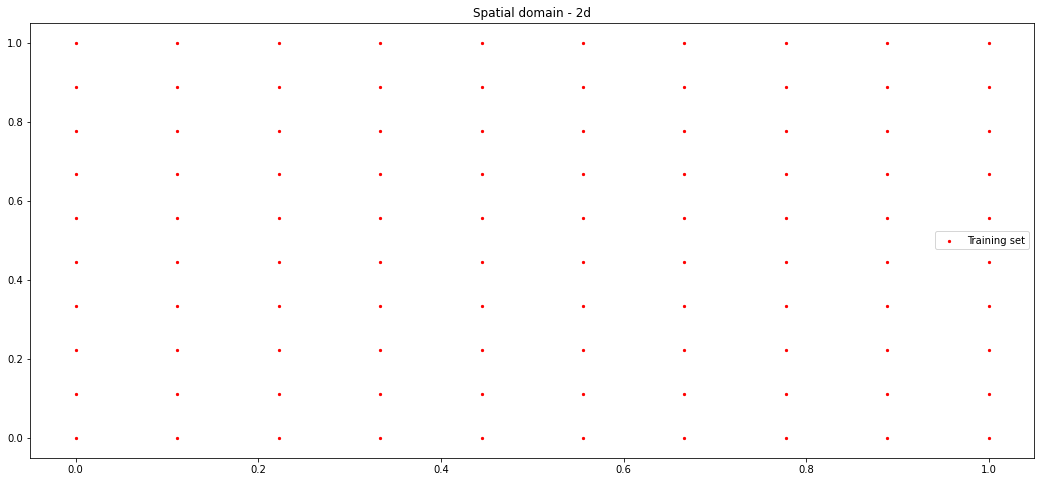

In [10]:
fig, ax = matplotlib.pyplot.subplots()
fig.set_size_inches(18, 8.0)
title = ax.set_title('Spatial domain - 2d')
graph = matplotlib.pyplot.scatter(XY_train[:,0], XY_train[:,1], color = 'red', s = 5)
__ = ax.legend(['Training set'])

matplotlib.pyplot.savefig('./Images/domain2d.png', facecolor = 'white', bbox_inches = 'tight')
matplotlib.pyplot.show()  

# Model initialization

In [11]:
key = jax.random.PRNGKey(parameters['seed'])
NN_MLP = MLP(key, parameters['layers'])                 
params = NN_MLP.MLP_create()            # Create the MLP
NN_eval = NN_MLP.NN_evaluation            # Evaluation function
solver = PINN(NN_eval, parameters['optimizer'])
opt_state = parameters['optimizer'].init(params)

# Training

In [9]:
loss_history = []
print("Training start")
if parameters['options'] == 1:            # start a new training
    # Main loop to solve the PDE
    for ibatch in range(parameters['maximum_num_epochs']+1):
        loss, params, opt_state = solver.train_step(params, opt_state, XY_train)

        loss_history.append(float(loss))

        if (ibatch%parameters['report_steps']) == parameters['report_steps']-1:
            print("Epoch n°{}: ".format(ibatch+1), loss.item())

        if loss <= numpy.min(loss_history): # save if the current state is the best 
            pickle.dump(params, open("./Checkpoints/params_helmholtz", "wb"))
            pickle.dump(opt_state, open("./Checkpoints/opt_state_helmholtz", "wb"))
            pickle.dump(loss_history, open("./Checkpoints/loss_history_helmholtz", "wb"))
        
elif parameters['options'] == 2:      # continue the last training
    params = pickle.load(open("./Checkpoints/params_helmholtz", "rb"))
    opt_state = pickle.load(open("./Checkpoints/opt_state_helmholtz", "rb"))
    loss_history = pickle.load(open("./Checkpoints/loss_history_helmholtz", "rb"))
    iepoch = len(loss_history)
    
    # Main loop to solve the PDE
    for ibatch in range(iepoch, parameters['maximum_num_epochs']+1):
        loss, params, opt_state = solver.train_step(params, opt_state, XY_train)

        loss_history.append(float(loss))

        if (ibatch%parameters['report_steps']) == parameters['report_steps']-1:
            print("Epoch n°{}: ".format(ibatch+1), loss.item())

        if loss <= numpy.min(loss_history): # save if the current state is the best 
            pickle.dump(params, open("./Checkpoints/params_helmholtz", "wb"))
            pickle.dump(opt_state, open("./Checkpoints/opt_state_helmholtz", "wb"))
            pickle.dump(loss_history, open("./Checkpoints/loss_history_helmholtz", "wb"))
else:
    params = pickle.load(open("./Checkpoints/params_helmholtz", "rb"))
    opt_state = pickle.load(open("./Checkpoints/opt_state_helmholtz", "rb"))
    loss_history = pickle.load(open("./Checkpoints/loss_history_helmholtz", "rb"))

Training start
Epoch n°1000:  5.508144004289995e-08
Epoch n°2000:  2.3492064342453148e-08
Epoch n°3000:  1.712214673089992e-08
Epoch n°4000:  1.3584209498974991e-08
Epoch n°5000:  6.782584311577836e-07
Epoch n°6000:  1.3726638647027041e-08
Epoch n°7000:  1.3330959503670555e-08
Epoch n°8000:  1.292204132239227e-08
Epoch n°9000:  1.2481982923987923e-08
Epoch n°10000:  1.2053273138377728e-08
Epoch n°11000:  1.1713291331651193e-08
Epoch n°12000:  1.1489137949481197e-08
Epoch n°13000:  1.1309575373356905e-08
Epoch n°14000:  1.1089247318201054e-08
Epoch n°15000:  1.077665372165983e-08
Epoch n°16000:  1.0324800746245108e-08
Epoch n°17000:  9.686227017984392e-09
Epoch n°18000:  8.846504053505464e-09
Epoch n°19000:  7.929729709992478e-09
Epoch n°20000:  7.032529485325194e-09
Epoch n°21000:  6.220678566630447e-09
Epoch n°22000:  5.553653758169135e-09
Epoch n°23000:  4.931916761029431e-09
Epoch n°24000:  4.710894492075254e-09
Epoch n°25000:  4.076219021928677e-09
Epoch n°26000:  3.72667566061403e

# Loss function plot

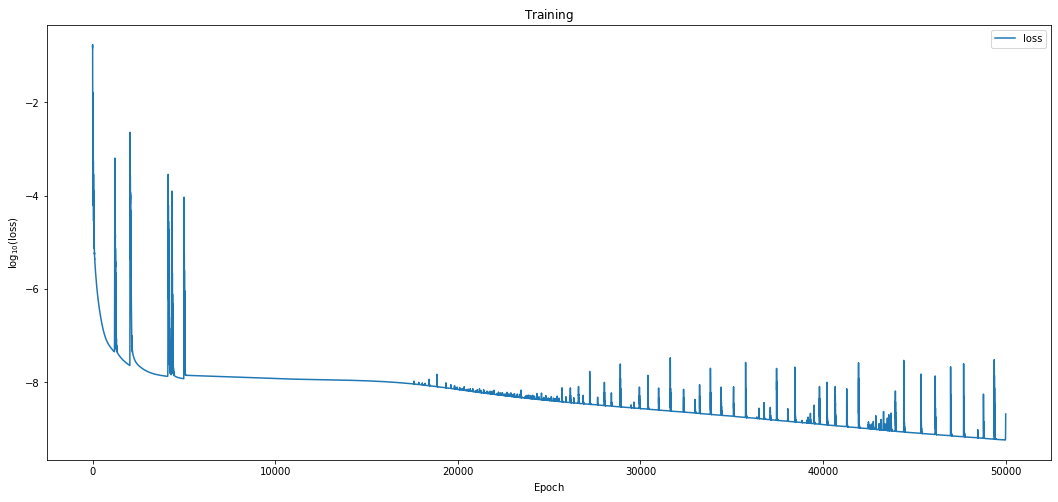

In [10]:
fig, ax = matplotlib.pyplot.subplots(1, 1)
fig.set_size_inches(18, 8.0)
__ = ax.plot(numpy.log10(loss_history))
xlabel = ax.set_xlabel(r'${\rm Epoch}$')
ylabel = ax.set_ylabel(r'$\log_{10}{\rm (loss)}$')
title = ax.set_title(r'${\rm Training}$')
ax.legend(['loss'])
matplotlib.pyplot.savefig('./Images/loss_function.png', facecolor = 'white', bbox_inches = 'tight')
matplotlib.pyplot.show()

# Load best params of the training

In [12]:
params = pickle.load(open("./Checkpoints/params_helmholtz", "rb"))

# Approximated solution plot

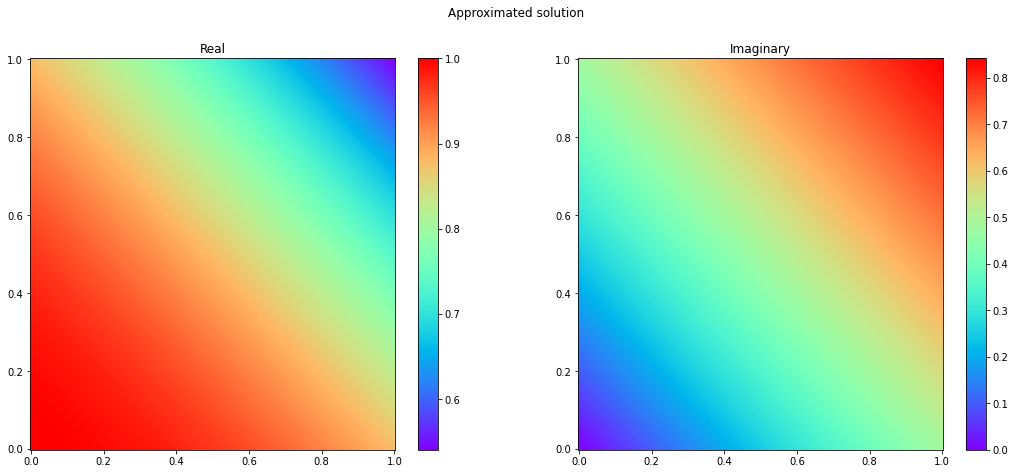

In [13]:
npoints = 200
real_values = numpy.zeros((npoints, npoints))
imag_values = numpy.zeros((npoints, npoints))

x, y = numpy.meshgrid(numpy.linspace(parameters['domain_bounds'][0,0], parameters['domain_bounds'][0,1], npoints), numpy.linspace(parameters['domain_bounds'][1,0], parameters['domain_bounds'][1,1], npoints))

fig, ax = matplotlib.pyplot.subplots(1,2)
fig.set_size_inches(18, 7.2)
title = fig.suptitle('Approximated solution')

for i in range(npoints):
    print("Plotting: {} out of {}".format(i+1, npoints), end='\r')
    real_values[i,:] = jax.numpy.real(functools.partial(solver.spatial_solution2d, params)(x[i,:], y[i,:])) 
    imag_values[i,:] = jax.numpy.imag(functools.partial(solver.spatial_solution2d, params)(x[i,:], y[i,:]))

title = ax[0].set_title('Real')
graph = ax[0].pcolormesh(x, y, real_values, cmap = 'rainbow')
matplotlib.pyplot.colorbar(graph, ax=ax[0])

title = ax[1].set_title('Imaginary')
graph = ax[1].pcolormesh(x, y, imag_values, cmap = 'rainbow')
matplotlib.pyplot.colorbar(graph, ax=ax[1])


matplotlib.pyplot.savefig('./Images/approximated_helmholtz.png', facecolor = 'white', bbox_inches = 'tight')
matplotlib.pyplot.show()  

# Analytical solution plot

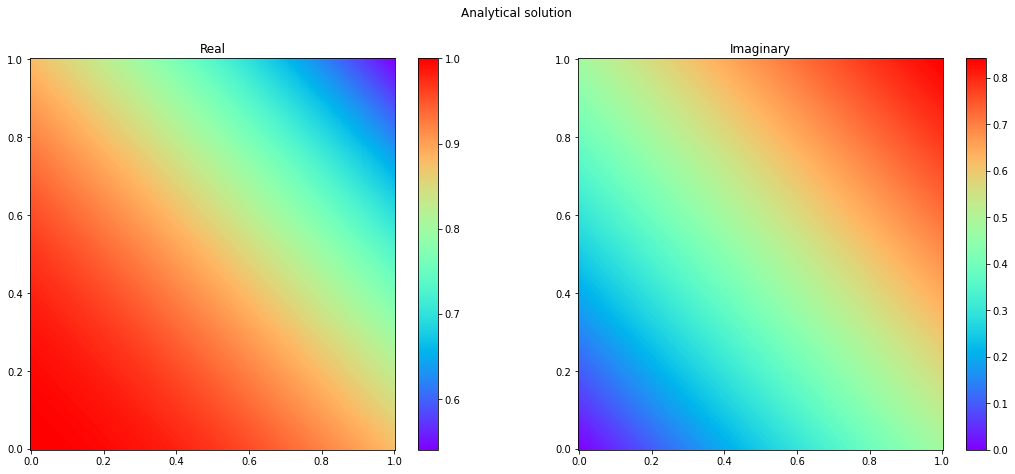

In [14]:
npoints = 200
real_values = numpy.zeros((npoints, npoints))
imag_values = numpy.zeros((npoints, npoints))

x, y = numpy.meshgrid(numpy.linspace(parameters['domain_bounds'][0,0], parameters['domain_bounds'][0,1], npoints), numpy.linspace(parameters['domain_bounds'][1,0], parameters['domain_bounds'][1,1], npoints))

fig, ax = matplotlib.pyplot.subplots(1,2)
fig.set_size_inches(18, 7.2)
title = fig.suptitle('Analytical solution')

for i in range(npoints):
    print("Plotting: {} out of {}".format(i+1, npoints), end='\r')
    real_values[i,:] = jax.numpy.real(functools.partial(analytical_solution)(x[i,:], y[i,:]))
    imag_values[i,:] = jax.numpy.imag(functools.partial(analytical_solution)(x[i,:], y[i,:]))

title = ax[0].set_title('Real')
graph = ax[0].pcolormesh(x, y, real_values, cmap = 'rainbow')
matplotlib.pyplot.colorbar(graph, ax=ax[0])

title = ax[1].set_title('Imaginary')
graph = ax[1].pcolormesh(x, y, imag_values, cmap = 'rainbow')
matplotlib.pyplot.colorbar(graph, ax=ax[1])


matplotlib.pyplot.savefig('./Images/analytical_helmholtz.png', facecolor = 'white', bbox_inches = 'tight')
matplotlib.pyplot.show()  

# Squared error plot

MSE:  2.0079658185253605e-14


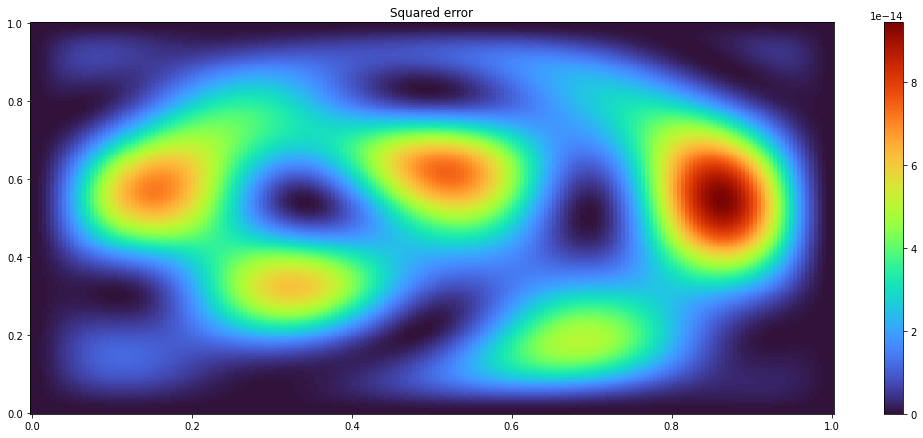

In [15]:
npoints = 200
values = numpy.zeros((npoints, npoints))

x, y = numpy.meshgrid(numpy.linspace(parameters['domain_bounds'][0,0], parameters['domain_bounds'][0,1], npoints), numpy.linspace(parameters['domain_bounds'][1,0], parameters['domain_bounds'][1,1], npoints))

fig, ax = matplotlib.pyplot.subplots()
fig.set_size_inches(18, 7.2)
title = ax.set_title('Squared error')

for i in range(npoints):
    print("Plotting: {} out of {}".format(i+1, npoints), end='\r')
    real_squared_error = (jax.numpy.real(functools.partial(solver.spatial_solution2d, params)(x[i,:], y[i,:])) - jax.numpy.real(functools.partial(analytical_solution)(x[i,:], y[i,:])))**2
    imag_squared_error = (jax.numpy.imag(functools.partial(solver.spatial_solution2d, params)(x[i,:], y[i,:])) - jax.numpy.imag(functools.partial(analytical_solution)(x[i,:], y[i,:])))**2
    values[i,:] = real_squared_error + imag_squared_error
    
print("MSE: ", numpy.mean(values.flatten()))
graph = matplotlib.pyplot.pcolormesh(x, y, values, cmap = 'turbo')
matplotlib.pyplot.colorbar()
matplotlib.pyplot.savefig('./Images/squared_error_helmholtz.png', facecolor = 'white', bbox_inches = 'tight')
matplotlib.pyplot.show()  